In [3]:
import json
import numpy as np
from math import log
import pandas as pd
import os

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)



In [4]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

In [5]:
optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)


In [13]:
import glob

filename = glob.glob(os.path.join(invasive_path,
                                    name, 
                                    f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
df = pd.read_csv(filename, index_col=0)

In [5]:
# Load handcrafted features
ef = pd.read_csv(config["handcrafted_features_path"], index_col=0)

In [6]:
ef_inv = ef.loc[df.index]

In [7]:
# Melt ef_inv to long format: one row per patch x feature with the feature value
idx_col = ef_inv.index.name if ef_inv.index.name is not None else "patch"
ef_inv_long = (
    ef_inv
    .reset_index()
    .rename(columns={ef_inv.index.name or "index": idx_col})
    .melt(id_vars=idx_col, var_name="feature", value_name="value")
)

# quick check
ef_inv_long.head()
ef_inv_long.set_index('patch', inplace=True)

**Statistical Testing: Kruskal-Wallis Test**

What it is:
The Kruskal-Wallis H-test is a non-parametric statistical test that answers: "Do these groups have different distributions?"

- Null hypothesis (H₀): All clusters have the same median value for this feature
- Alternative (H₁): At least one cluster has a different median


In [8]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge cluster labels with features
ef_inv_long_clusters = ef_inv_long.merge(df[['predicted_label']], left_index=True, right_index=True)
ef_inv_long_clusters.head()

# Compute statistics for each feature across clusters
feature_stats = []

for feature_name in ef_inv_long_clusters['feature'].unique():
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    
    # Group by cluster
    cluster_groups = [group['value'].values for name, group in feature_data.groupby('predicted_label')]
    
    # Kruskal-Wallis H-test (non-parametric alternative to one-way ANOVA)
    if len(cluster_groups) > 1:
        h_stat, p_value = stats.kruskal(*cluster_groups)
    else:
        h_stat, p_value = np.nan, np.nan
    
    # Compute mean and std for each cluster
    cluster_stats = feature_data.groupby('predicted_label')['value'].agg(['mean', 'std', 'median'])
    
    # Compute overall statistics
    overall_mean = feature_data['value'].mean()
    overall_std = feature_data['value'].std()
    
    # Coefficient of variation across cluster means
    cv_across_clusters = cluster_stats['mean'].std() / cluster_stats['mean'].mean() if cluster_stats['mean'].mean() != 0 else 0
    
    feature_stats.append({
        'feature': feature_name,
        'kruskal_h': h_stat,
        'p_value': p_value,
        'cv_across_clusters': cv_across_clusters,
        'overall_mean': overall_mean,
        'overall_std': overall_std,
        'max_cluster_mean': cluster_stats['mean'].max(),
        'min_cluster_mean': cluster_stats['mean'].min(),
        'mean_range': cluster_stats['mean'].max() - cluster_stats['mean'].min()
    })

df_feature_stats = pd.DataFrame(feature_stats).sort_values('p_value')


In [9]:
# Apply Bonferroni correction for multiple testing
n_features = len(df_feature_stats)
df_feature_stats['p_value_corrected'] = df_feature_stats['p_value'] * n_features
df_feature_stats['significant'] = df_feature_stats['p_value_corrected'] < 0.05

print(f"Total features: {n_features}")
print(f"Significant features (Bonferroni corrected p < 0.05): {df_feature_stats['significant'].sum()}")
print(f"\nTop 10 most discriminative features:")
df_feature_stats[df_feature_stats['significant']].head(10)


Total features: 133
Significant features (Bonferroni corrected p < 0.05): 55

Top 10 most discriminative features:


,feature,kruskal_h,p_value,cv_across_clusters,overall_mean,overall_std,max_cluster_mean,min_cluster_mean,mean_range,p_value_corrected,significant
78,Nuclei-Composition_number_of_cells,8290.635764,0.0,0.302592,37.022388,20.149466,44.712600,18.583594,26.129006,0.0,True
107,ExtraCell-Color_mean_color_B,4133.922788,0.0,0.061063,155.875397,19.774334,169.928553,141.469142,28.459411,0.0,True
108,ExtraCell-Color_mean_intensity,5754.994728,0.0,0.099709,133.080446,22.866603,154.372564,114.091523,40.281041,0.0,True
109,ExtraCell-Color_std_color_R,12411.086373,0.0,0.157553,52.784041,12.548766,61.351012,42.433935,18.917076,0.0,True
110,ExtraCell-Color_std_color_G,12943.772509,0.0,0.196793,44.759655,12.619998,56.592919,34.229054,22.363865,0.0,True
111,ExtraCell-Color_std_color_B,11818.139731,0.0,0.204727,38.780016,12.137947,49.125114,28.413869,20.711245,0.0,True
112,ExtraCell-Color_std_intensity,12869.708262,0.0,0.184852,45.145782,12.189337,55.467726,34.699785,20.767941,0.0,True
113,ExtraCell-Color_skew_color_R,6451.922625,0.0,-3.283077,-0.091322,0.613829,0.425986,-0.782930,1.208917,0.0,True
114,ExtraCell-Color_skew_color_G,6168.603639,0.0,-2.942259,-0.107304,0.612468,0.425781,-0.762792,1.188574,0.0,True
115,ExtraCell-Color_skew_color_B,5902.155977,0.0,-0.852837,-0.400446,0.574794,0.081138,-1.024126,1.105264,0.0,True


**Effect Size: Cohen's d**
P-value tells you if there's a difference

Cohen's d tells you how big the difference is

For each significant feature, you find which cluster is most different from the others
Cohen's d quantifies: (mean of special cluster - mean of others) / pooled standard deviation
- |d| > 0.8 = large effect
- |d| > 0.5 = medium effect
- |d| > 0.2 = small effect

In [10]:
# Identify cluster-specific features (features where one cluster is very different)
cluster_specific_features = []

for feature_name in df_feature_stats[df_feature_stats['significant']]['feature']:

    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    cluster_means = feature_data.groupby('predicted_label')['value'].mean()
    
    # Find cluster with max deviation from overall mean
    overall_mean = feature_data['value'].mean()
    deviations = np.abs(cluster_means - overall_mean)
    max_cluster = deviations.idxmax()
    max_deviation = deviations.max()
    
    # Calculate effect size (Cohen's d) for max cluster vs others
    max_cluster_values = feature_data[feature_data['predicted_label'] == max_cluster]['value']
    other_values = feature_data[feature_data['predicted_label'] != max_cluster]['value']
    
    cohens_d = (max_cluster_values.mean() - other_values.mean()) / np.sqrt(
        ((len(max_cluster_values) - 1) * max_cluster_values.std()**2 + 
         (len(other_values) - 1) * other_values.std()**2) / 
        (len(max_cluster_values) + len(other_values) - 2)
    )
    
    cluster_specific_features.append({
        'feature': feature_name,
        'distinctive_cluster': max_cluster,
        'cohens_d': cohens_d,
        'cluster_mean': cluster_means[max_cluster],
        'overall_mean': overall_mean,
        'deviation': max_deviation
    })

df_cluster_specific = pd.DataFrame(cluster_specific_features).sort_values('cohens_d', key=abs, ascending=False)

print("Top cluster-specific features (sorted by effect size):")

Top cluster-specific features (sorted by effect size):


In [11]:
# Summary: Features most characteristic of each cluster
print("=" * 80)
print("CLUSTER-SPECIFIC FEATURE SIGNATURES")
print("=" * 80)

for cluster_id in sorted(df['predicted_label'].unique()):
    cluster_features = df_cluster_specific[df_cluster_specific['distinctive_cluster'] == cluster_id]
    cluster_features = cluster_features.nlargest(5, 'cohens_d')
    
    print(f"\n{'Cluster ' + str(cluster_id):=^80}")
    # print(f"{'Feature':<40} {'Cohen\'s d':>12} {'Direction':>12}")
    print("-" * 80)
    
    for _, row in cluster_features.iterrows():
        direction = "Higher" if row['cohens_d'] > 0 else "Lower"
        print(f"{row['feature']:<40} {row['cohens_d']:>12.3f} {direction:>12}")
    
    if len(cluster_features) == 0:
        print("  (No highly distinctive features)")

print("\n" + "=" * 80)

CLUSTER-SPECIFIC FEATURE SIGNATURES

===================================Cluster 0====================================
--------------------------------------------------------------------------------
Nuclei-Composition_density_of_S_cells          -0.169        Lower

===================================Cluster 1====================================
--------------------------------------------------------------------------------
  (No highly distinctive features)

===================================Cluster 2====================================
--------------------------------------------------------------------------------
ExtraCell-Color_std_color_R                    -1.057        Lower
ExtraCell-Color_std_color_B                    -1.101        Lower
ExtraCell-Color_std_intensity                  -1.105        Lower

===================================Cluster 3====================================
--------------------------------------------------------------------------------
Nuclei-Co

## Cluster-Specific Feature Signatures

/tmp/ipykernel_727756/763802020.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


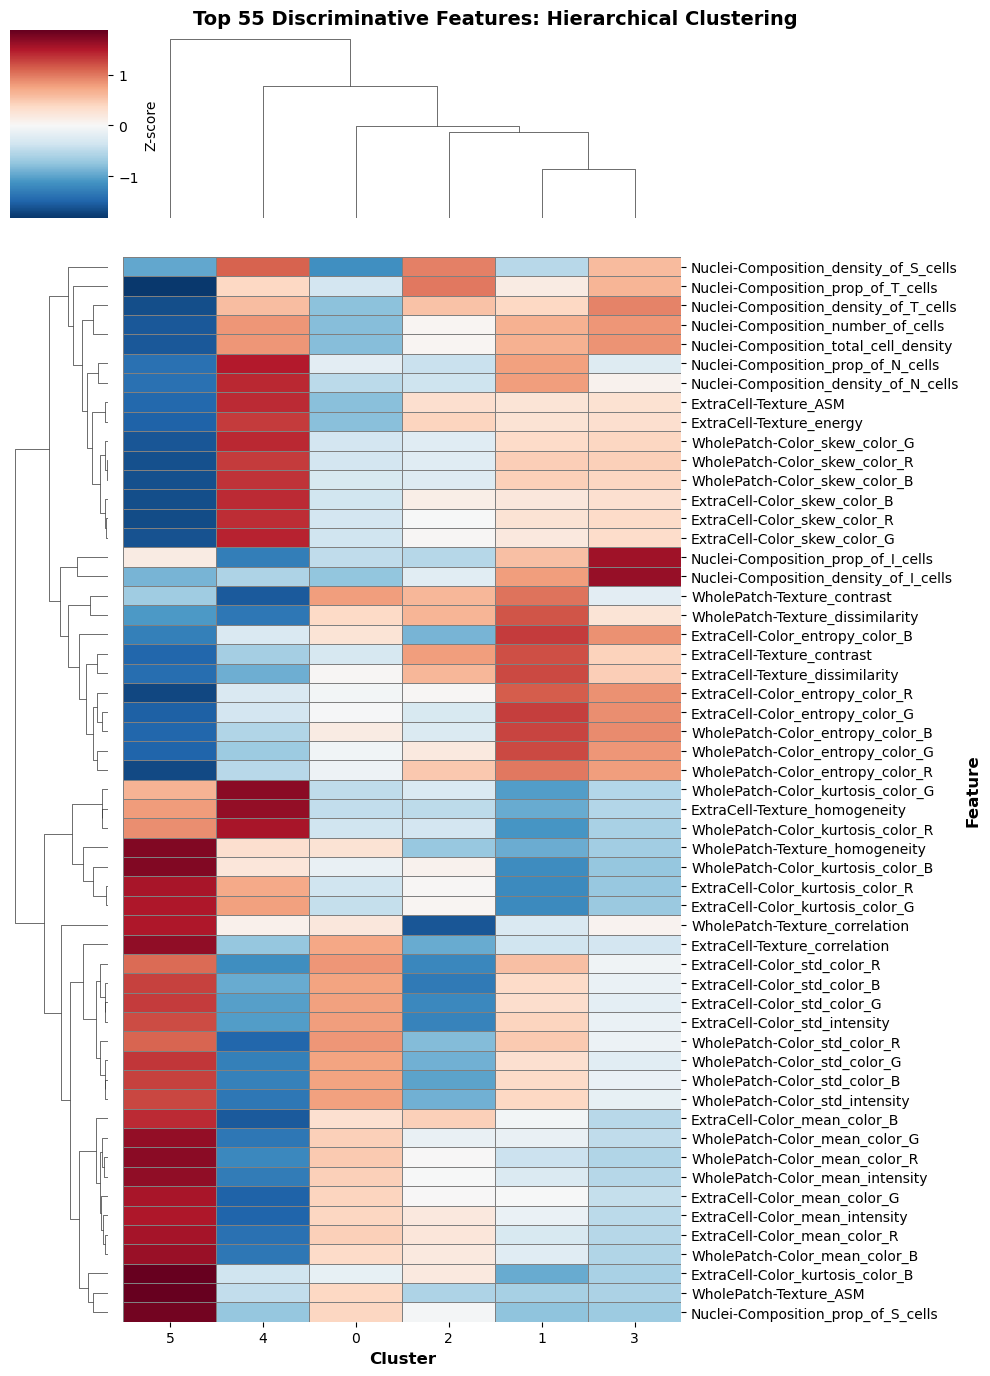

In [12]:
# Heatmap: Mean feature values per cluster (top 30 features)
top_n_heatmap = len(df_feature_stats[df_feature_stats['significant']])
top_features_heatmap = df_feature_stats.nsmallest(top_n_heatmap, 'p_value')['feature'].values

# Create pivot table: features x clusters
heatmap_data = []
for feature_name in top_features_heatmap:
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    cluster_means = feature_data.groupby('predicted_label')['value'].mean()
    heatmap_data.append(cluster_means)

df_heatmap = pd.DataFrame(heatmap_data, index=top_features_heatmap)

# Normalize by row (z-score) to see relative differences
df_heatmap_norm = df_heatmap.sub(df_heatmap.mean(axis=1), axis=0).div(df_heatmap.std(axis=1), axis=0)

# Clustered heatmap with dendrogram
g = sns.clustermap(df_heatmap_norm, 
                   cmap='RdBu_r', 
                   center=0,
                   figsize=(10, 14),
                   cbar_kws={'label': 'Z-score'},
                   linewidths=0.5, 
                   linecolor='gray',
                   row_cluster=True,  # Cluster features (rows)
                   col_cluster=True,  # Cluster patient groups (columns)
                   dendrogram_ratio=0.15,
                   cbar_pos=(0.02, 0.83, 0.03, 0.15))

g.ax_heatmap.set_xlabel('Cluster', fontsize=12, fontweight='bold')
g.ax_heatmap.set_ylabel('Feature', fontsize=12, fontweight='bold')
g.fig.suptitle(f'Top {top_n_heatmap} Discriminative Features: Hierarchical Clustering', 
               fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

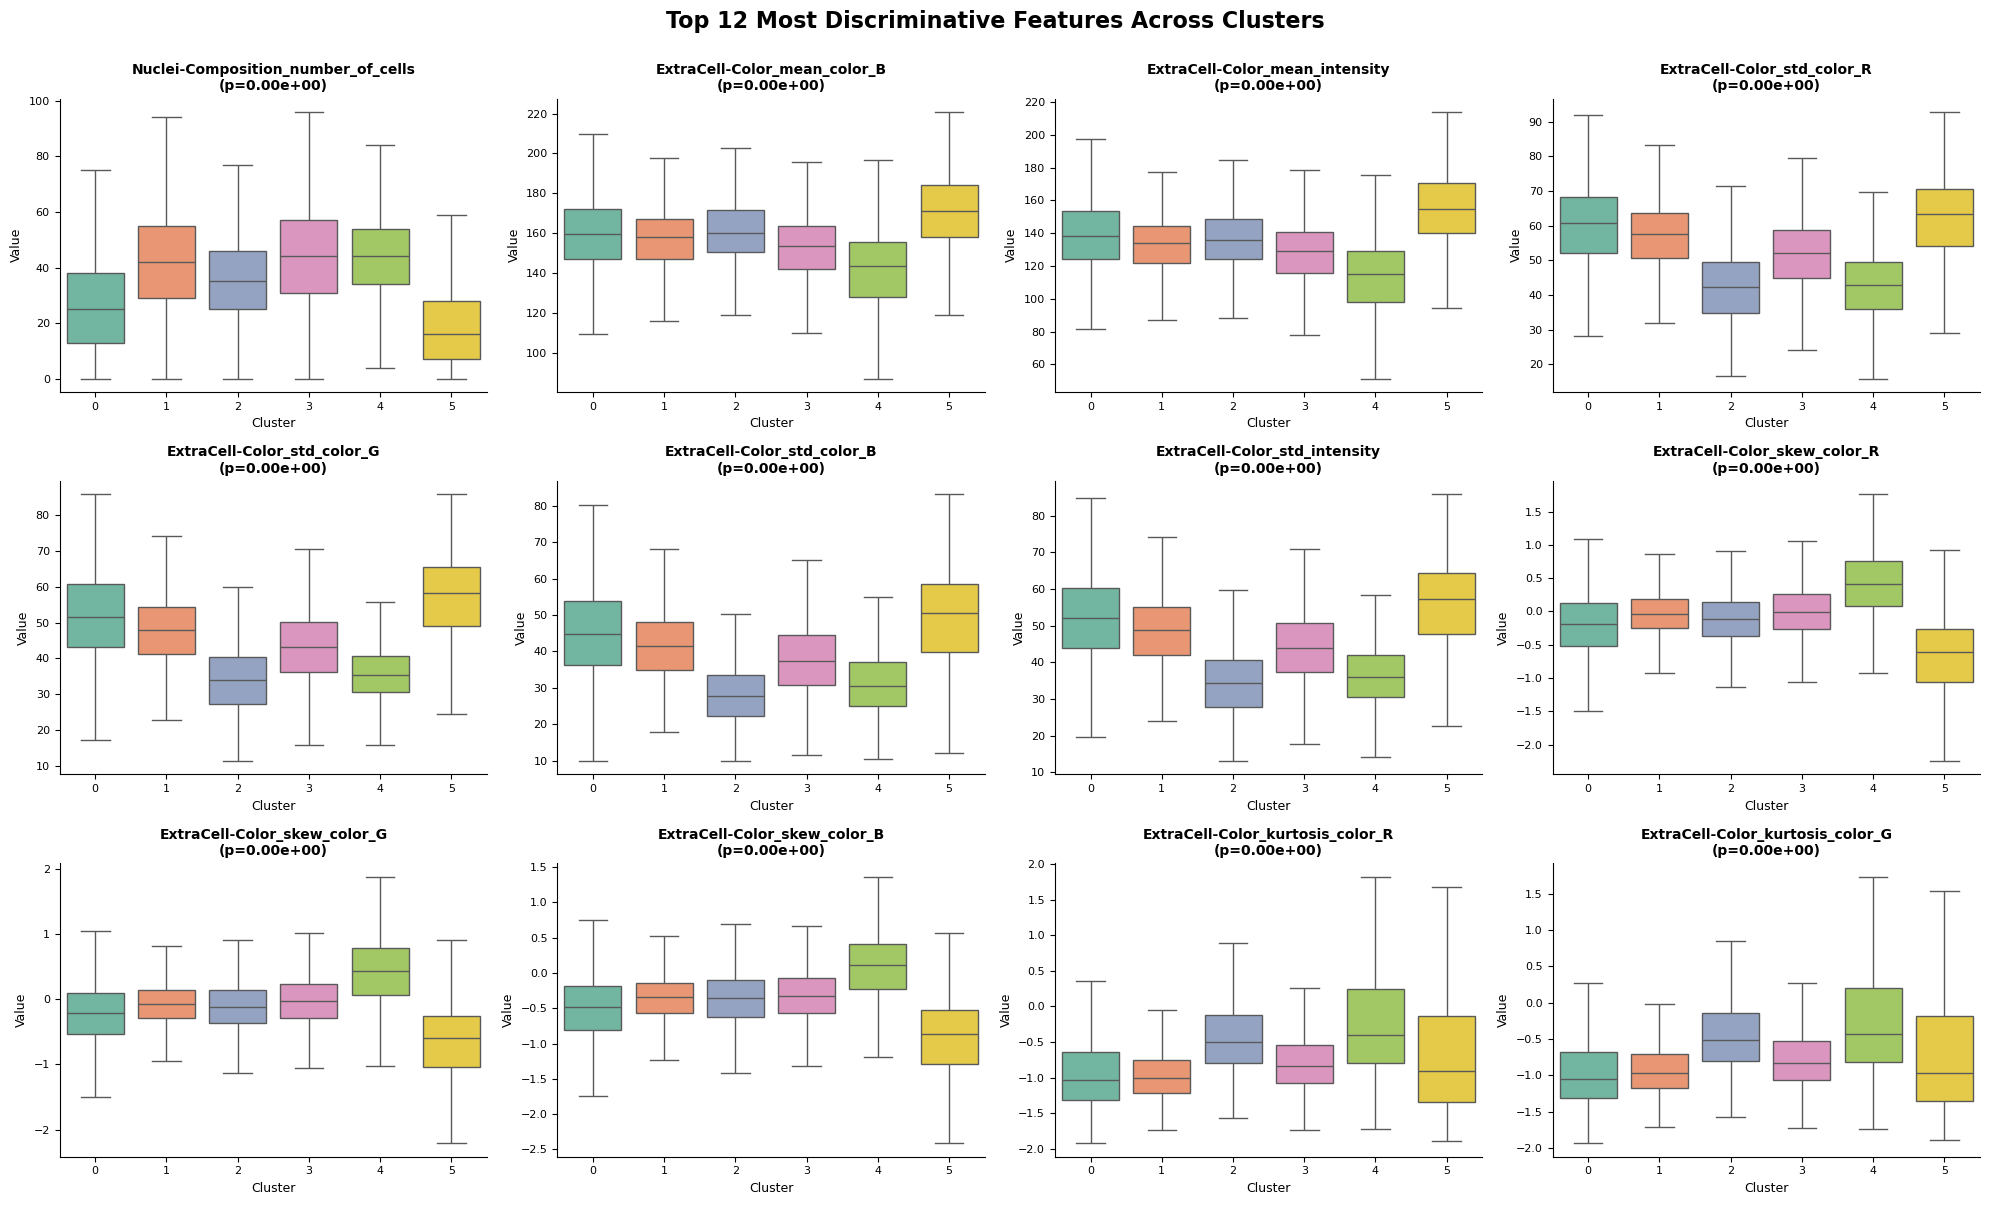

In [13]:
# Box plots for top 12 most discriminative features
import warnings
# remove futurewarnings
warnings.filterwarnings("ignore", category=FutureWarning)
top_n = 12
top_features_list = df_feature_stats.nsmallest(top_n, 'p_value')['feature'].values

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, feature_name in enumerate(top_features_list):
    ax = axes[idx]
    feature_data = ef_inv_long_clusters[ef_inv_long_clusters['feature'] == feature_name]
    
    # Create box plot

    sns.boxplot(data=feature_data, x='predicted_label', y='value', ax=ax,
                palette='Set2', showfliers=False)
    
    # Get p-value for title
    p_val = df_feature_stats[df_feature_stats['feature'] == feature_name]['p_value'].values[0]
    
    ax.set_title(f'{feature_name}\n(p={p_val:.2e})', fontsize=10, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=9)
    ax.set_ylabel('Value', fontsize=9)
    ax.tick_params(labelsize=8)

plt.suptitle('Top 12 Most Discriminative Features Across Clusters', 
             fontsize=16, fontweight='bold', y=1.00)
sns.despine()
plt.tight_layout()
plt.show()

In [14]:

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

def get_pixel_annotation(spot_name, patches_info):
    info_patch = [patch for patch in patches_info if spot_name in patch["name"]][0]
    slide_name = info_patch["path_origin"].split("/")[-1].split(".")[0]
    annotated_slide = f"/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imageAnnotations/{slide_name}.png"
    annotated = Image.open(annotated_slide).convert("RGB").resize((9523, 9523))

    if "TNBC78" in spot_name:
        print("Rotating TNBC78")
        annotated = np.rot90(annotated, k=-1)

    if "TNBC92" in spot_name:
        print("Rotating TNBC92")
        annotated = np.rot90(annotated, k=2)

    # img_hd = Image.open(slide_hd)
    factor = 10 / 3
    patch_low_res_x = info_patch["start_width_origin"] / factor
    patch_low_res_y = info_patch["start_height_origin"] / factor
    patch_size = int(252 / factor)


    img_arr = np.array(annotated)
    # Calculate crop indices
    x_start = int(patch_low_res_x)
    y_start = int(patch_low_res_y)
    x_end = x_start + patch_size
    y_end = y_start + patch_size


    # Use numpy slicing to extract the region
    annot_patch = img_arr[y_start:y_end, x_start:x_end]

    return annot_patch


In [18]:
import gzip
import pickle

with gzip.open(config["patches_info_path"]) as f:
    patches_info = pickle.load(f)

In [19]:
def count_annotation_colors(annot, max_display=50, show_plot=True, show_table=True):
    """
    Count pixels per RGB color in an annotation image.
    
    Parameters:
    -----------
    annot : numpy array or PIL image
        The annotation image to analyze
    max_display : int, optional (default=50)
        Maximum number of unique colors to display individually. 
        Colors beyond this are aggregated as "Other"
    show_plot : bool, optional (default=True)
        Whether to display the bar plot
    show_table : bool, optional (default=True)
        Whether to display the dataframe table
        
    Returns:
    --------
    dict
        Dictionary mapping hex colors to their percentage in the image
        Format: {'#rrggbb': percentage, ...}
    """
    from IPython.display import display
    
    arr = np.array(annot)  # ensure numpy array

    # Handle grayscale or alpha channel
    if arr.ndim == 2:
        arr = np.stack([arr] * 3, axis=-1)
    if arr.shape[2] == 4:
        arr = arr[:, :, :3]

    h, w, _ = arr.shape
    pixels = arr.reshape(-1, 3)

    # Count unique RGB tuples
    unique, counts = np.unique(pixels, axis=0, return_counts=True)
    rgb_tuples = [tuple(row) for row in unique]
    df_colors = pd.DataFrame({
        'rgb': rgb_tuples,
        'hex': ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in rgb_tuples],
        'count': counts
    })
    df_colors = df_colors.sort_values('count', ascending=False).reset_index(drop=True)
    df_colors['pct'] = df_colors['count'] / (h * w) * 100

    # If too many unique colors, keep top N and aggregate the rest as "Other"
    if len(df_colors) > max_display:
        top = df_colors.iloc[:max_display].copy()
        other = df_colors.iloc[max_display:].agg({'count': 'sum', 'pct': 'sum'})
        other_row = {'rgb': None, 'hex': '#808080', 'count': int(other['count']), 'pct': float(other['pct'])}
        df_plot = pd.concat([top, pd.DataFrame([other_row])], ignore_index=True)
    else:
        df_plot = df_colors

    print(f"Image size: {h} x {w} = {h*w} pixels")
    
    if show_table:
        display(df_plot[['hex', 'count', 'pct']])

    # Plot colored bars matching the actual colors
    if show_plot:
        fig, ax = plt.subplots(figsize=(8, max(3, 0.25 * len(df_plot))))
        bar_colors = df_plot['hex'].tolist()
        ax.bar(range(len(df_plot)), df_plot['count'], color=bar_colors)
        ax.set_xticks(range(len(df_plot)))
        ax.set_xticklabels(df_plot['hex'].tolist(), rotation=90, fontsize=8)
        ax.set_ylabel('Pixel count')
        ax.set_title('Pixel counts by color (hex shown on x-axis)')
        plt.tight_layout()
        plt.show()
    
    # Return dictionary with all colors (not just top N)
    return dict(zip(df_colors['hex'], df_colors['pct']))


# Example usage


In [20]:
annot = get_pixel_annotation("TNBC11_CN6_C1_patch002", patches_info)
color_dict = count_annotation_colors(annot, show_plot=False, show_table=False)

Image size: 75 x 75 = 5625 pixels


In [21]:
def get_all_patch_annotations_efficient(patch_names, patches_info):
    """
    Extract annotation color distributions for all patches efficiently.
    Loads each slide only once and processes all patches from that slide.
    
    Parameters:
    -----------
    patch_names : list or pd.Index
        List of patch/spot names to process
    patches_info : list
        Patches metadata containing origin paths and coordinates
        
    Returns:
    --------
    dict
        Dictionary mapping patch names to their color distribution dictionaries
        Format: {patch_name: {'#rrggbb': percentage, ...}, ...}
    """
    from collections import defaultdict
    from PIL import Image
    Image.MAX_IMAGE_PIXELS = None
    
    # Group patches by slide
    slide_to_patches = defaultdict(list)
    
    for patch_name in patch_names:
        # Find patch info
        info_patch = next((patch for patch in patches_info if patch_name in patch["name"]), None)
        if info_patch is None:
            print(f"Warning: {patch_name} not found in patches_info")
            continue
            
        slide_name = info_patch["path_origin"].split("/")[-1].split(".")[0]
        slide_to_patches[slide_name].append({
            'name': patch_name,
            'info': info_patch
        })
    
    print(f"Found {len(slide_to_patches)} unique slides to process")
    
    # Process each slide once
    results = {}
    factor = 10 / 3
    patch_size = int(252 / factor)
    
    for slide_idx, (slide_name, patches) in enumerate(slide_to_patches.items(), 1):
        print(f"\nProcessing slide {slide_idx}/{len(slide_to_patches)}: {slide_name} ({len(patches)} patches)")
        
        # Load the annotation slide once
        annotated_slide_path = f"/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imageAnnotations/{slide_name}.png"
        try:
            annotated = Image.open(annotated_slide_path).convert("RGB").resize((9523, 9523))
        except FileNotFoundError:
            print(f"  Warning: Annotation file not found for {slide_name}")
            continue
        
        # Apply rotation if needed
        if "TNBC78" in slide_name:
            print("  Applying TNBC78 rotation")
            annotated = np.rot90(annotated, k=-1)
        elif "TNBC92" in slide_name:
            print("  Applying TNBC92 rotation")
            annotated = np.rot90(annotated, k=2)
        
        img_arr = np.array(annotated)
        
        # Process all patches from this slide
        for patch in patches:
            patch_name = patch['name']
            info_patch = patch['info']
            
            # Calculate patch coordinates
            patch_low_res_x = info_patch["start_width_origin"] / factor
            patch_low_res_y = info_patch["start_height_origin"] / factor
            
            x_start = int(patch_low_res_x)
            y_start = int(patch_low_res_y)
            x_end = x_start + patch_size
            y_end = y_start + patch_size
            
            # Extract annotation patch
            annot_patch = img_arr[y_start:y_end, x_start:x_end]
            
            # Count colors (without plotting/displaying)
            color_dict = count_annotation_colors(annot_patch, 
                                                show_plot=False, 
                                                show_table=False)
            
            results[patch_name] = color_dict
        
        print(f"  Completed {len(patches)} patches from {slide_name}")
    
    print(f"\n✓ Total patches processed: {len(results)}/{len(patch_names)}")
    return results

In [22]:
# Process all patches in df efficiently
patch_annotations = get_all_patch_annotations_efficient(df.index, patches_info)

Found 85 unique slides to process

Processing slide 1/85: TNBC11_CN6_C1 (713 patches)
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pixels
Image size: 75 x 75 = 5625 pix

In [24]:
len(patch_annotations)

43819

In [25]:
with open(os.path.join(invasive_path,
             name,
             "invasive_patch_annotations.json"), "w") as f:
    json.dump(patch_annotations, f)


In [6]:
# Reload the patch annotation

import json 
import os
import pandas as pd

with open(os.path.join(invasive_path,
             name,
             "invasive_patch_annotations.json"), "r") as f:
    patch_annotations = json.load(f)

In [7]:
patch_annotations['TNBC11_CN6_C1_patch002']

{'#e9d1bb': 38.48888888888889,
 '#000000': 37.92,
 '#ff9980': 21.173333333333332,
 '#40e5f6': 2.417777777777778}

In [8]:
df_annot = pd.DataFrame.from_dict(patch_annotations, orient="index")

In [ ]:
colors = {"Nothing": "#ffffff", 
          "Tumor": "#017801",
          "Necrosis": "#000000",
          "Fat tissue": "#000080",
          "Low TIL stroma": "#ff904f",
          "Vessels": "#dc0000",
          "Artefacts": "#6e2400",
          "Lactiferous duct": "#9980e6",
          "High TIL stroma": "#e9e900",
          "in situ": "#ccffcc", 
          "Lymphoid nodule": "#80801a", 
          "Hole (whitespace)": "#40e5f6", 
          "Lymphocyte": "#c4417f", 
          "Stroma cell": "#ff9980", 
          "Nerve": "#4d8080", 
          "Heterologous elements": "#808080", 
          "Acellular stroma": "#e9d1bb",
          "Tumor region": "#258a15"}

mapping = {"invasive cancer": ["Tumor", "Tumor region"],
           "cancer in situ": ["in situ"],
           "immune infiltrate": ["High TIL stroma", "Lymphocyte", "Lymphoid nodule"],
           "connective tissue": ["Nerve", "Acellular stroma", "Stroma cell", "Low TIL stroma", "Vessels"],
           "breast glands": ["Lactiferous duct"],
           "adipose tissue": ["Fat tissue"], 
           "nothing": ["Nothing", "Hole (whitespace)", "Artefacts", "Heterologous elements"], 
           "necrosis": ["Necrosis"]}

PALETTE = {
        "invasive cancer": "red",
        "cancer in situ": "orange",
        "immune infiltrate": "yellow",
        "breast glands": "green",
        "connective tissue": "blue",
        "adipose tissue": "cyan",
        "nothing": "lightgrey",
        "necrosis": "black"
    }

In [10]:
colors_annot = list(colors.values())

In [11]:
df_annot_simp = df_annot[[c for c in colors_annot if c in df_annot.columns]]

In [12]:
df_annot_simp

,#ffffff,#017801,#000000,#000080,#ff904f,#dc0000,#6e2400,#9980e6,#e9e900,#ccffcc,#80801a,#40e5f6,#c4417f,#ff9980,#4d8080,#e9d1bb,#258a15
TNBC11_CN6_C1_patch002,NaN,NaN,37.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.417778,NaN,21.173333,NaN,38.488889,NaN
TNBC11_CN6_C1_patch010,NaN,24.284444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.640000,NaN,14.026667,NaN,5.048889,NaN
TNBC11_CN6_C1_patch012,NaN,55.573333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.280000,NaN,0.124444,NaN,7.022222,NaN
TNBC11_CN6_C1_patch018,NaN,41.991111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.591111,NaN,NaN,NaN,10.417778,NaN
TNBC11_CN6_C1_patch019,NaN,28.622222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.182222,NaN,22.222222,NaN,9.973333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TNBC77_CN39_C1_patch187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TNBC77_CN39_C1_patch410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TNBC77_CN39_C1_patch670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TNBC91_CN46_C2_patch270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
idx_col = df_annot_simp.index.name if df_annot_simp.index.name is not None else "patch"
df_annot_simp_long = (
    df_annot_simp
    .reset_index()
    .rename(columns={df_annot_simp.index.name or "index": idx_col})
    .melt(id_vars=idx_col, var_name="feature", value_name="value")
)


In [19]:
df_annot_simp_long.replace(np.nan, 0, inplace=True)

In [21]:
df

,predicted_label,label
TNBC11_CN6_C1_patch002,2,NaN
TNBC11_CN6_C1_patch004,0,NaN
TNBC11_CN6_C1_patch010,2,NaN
TNBC11_CN6_C1_patch012,2,NaN
TNBC11_CN6_C1_patch013,2,NaN
...,...,...
TNBC9_spot50x16,1,NaN
TNBC9_spot50x18,1,NaN
TNBC9_spot52x18,0,NaN
TNBC9_spot6x52,3,NaN


In [25]:
df_annot_simp_long = df_annot_simp_long.merge(df[["predicted_label"]], left_on="patch", right_index=True)

In [28]:
# Statistical testing: Which tissue colors differ across clusters?
import scipy.stats as stats
tissue_stats = []

for color in df_annot_simp_long['feature'].unique():
    tissue_data = df_annot_simp_long[df_annot_simp_long['feature'] == color]
    
    # Group by cluster
    cluster_groups = [group['value'].values for name, group in tissue_data.groupby('predicted_label')]
    
    # Kruskal-Wallis test
    if len(cluster_groups) > 1:
        h_stat, p_value = stats.kruskal(*cluster_groups)
    else:
        h_stat, p_value = np.nan, np.nan
    
    # Compute mean percentage per cluster
    cluster_means = tissue_data.groupby('predicted_label')['value'].mean()
    
    tissue_stats.append({
        'color': color,
        'kruskal_h': h_stat,
        'p_value': p_value,
        'overall_mean': tissue_data['value'].mean(),
        'max_cluster_mean': cluster_means.max(),
        'min_cluster_mean': cluster_means.min(),
        'mean_range': cluster_means.max() - cluster_means.min()
    })

df_tissue_stats = pd.DataFrame(tissue_stats).sort_values('p_value')

# Apply Bonferroni correction
n_tissues = len(df_tissue_stats)
df_tissue_stats['p_value_corrected'] = df_tissue_stats['p_value'] * n_tissues
df_tissue_stats['significant'] = df_tissue_stats['p_value_corrected'] < 0.05

print(f"Total tissue colors: {n_tissues}")
print(f"Significant tissue colors (Bonferroni corrected p < 0.05): {df_tissue_stats['significant'].sum()}")
print(f"\nTop discriminative tissue types:")
df_tissue_stats[df_tissue_stats['significant']].head(10)

Total tissue colors: 17
Significant tissue colors (Bonferroni corrected p < 0.05): 14

Top discriminative tissue types:


,color,kruskal_h,p_value,overall_mean,max_cluster_mean,min_cluster_mean,mean_range,p_value_corrected,significant
12,#c4417f,3008.542739,0.000000e+00,8.714476,12.776200,4.645188,8.131011,0.000000e+00,True
2,#000000,1447.728843,6.257854e-311,4.184463,9.255421,0.370832,8.884589,1.063835e-309,True
11,#40e5f6,1372.238892,1.425684e-294,11.250252,18.500712,7.673283,10.827429,2.423662e-293,True
0,#ffffff,1215.375155,1.372759e-260,4.074773,9.295056,1.719979,7.575076,2.333690e-259,True
1,#017801,1079.406638,3.851497e-231,42.384912,48.773959,28.350347,20.423611,6.547544e-230,True
15,#e9d1bb,1005.426407,4.018549e-215,4.490498,6.222131,2.545399,3.676731,6.831534e-214,True
4,#ff904f,664.514614,2.306852e-141,1.648673,2.697146,0.273068,2.424077,3.921649e-140,True
13,#ff9980,587.208713,1.173471e-124,7.611898,9.291160,4.842857,4.448303,1.994901e-123,True
6,#6e2400,247.538246,1.854760e-51,1.866582,2.923771,0.345710,2.578061,3.153092e-50,True
3,#000080,231.846952,4.298355e-48,0.415589,0.857559,0.046235,0.811324,7.307204e-47,True


In [29]:
# Compute mean percentage of each tissue type per cluster
tissue_by_cluster = df_annot_simp_long.groupby(['predicted_label', 'feature'])['value'].mean().reset_index()
tissue_by_cluster_pivot = tissue_by_cluster.pivot(index='predicted_label', columns='feature', values='value')

print("Mean tissue percentage per cluster:")
tissue_by_cluster_pivot

Mean tissue percentage per cluster:


feature,#000000,#000080,#017801,#258a15,#40e5f6,#4d8080,#6e2400,#80801a,#9980e6,#c4417f,#ccffcc,#dc0000,#e9d1bb,#e9e900,#ff904f,#ff9980,#ffffff
predicted_label,,,,,,,,,,,,,,,,,
0,5.948237,0.857559,42.681375,0.035912,12.277962,0.00000,2.678826,0.142125,0.030166,4.645188,0.081466,0.042235,2.545399,0.047544,0.273068,6.613936,5.335762
1,0.370832,0.368111,46.024162,0.016718,12.359978,0.00000,0.856622,0.000000,0.080331,12.776200,0.121906,0.065831,4.083747,0.168889,1.571689,8.574253,3.103167
2,9.255421,0.046235,44.501324,0.000000,10.258514,0.00000,0.345710,0.098490,0.006779,5.104648,0.059837,0.034937,5.415089,0.315390,1.958024,7.488770,1.719979
3,2.059865,0.375500,40.684275,0.072493,7.673283,0.00066,2.033686,0.142260,0.237728,12.629095,0.100577,0.042141,6.222131,0.659602,2.697146,8.489408,3.843158
4,0.480572,0.062974,48.773959,0.000000,18.500712,0.00000,2.429641,0.048746,0.080028,9.446896,0.000000,0.045966,3.013650,0.637863,2.082319,4.842857,3.411191
5,7.021694,0.311153,28.350347,0.178535,17.056146,0.00000,2.923771,0.000000,0.104000,5.575826,0.032396,0.013806,3.723951,0.032132,0.578444,9.291160,9.295056


In [30]:
# Identify dominant tissue type for each cluster
print("=" * 80)
print("CLUSTER-SPECIFIC TISSUE COMPOSITION")
print("=" * 80)

for cluster_id in sorted(df_annot_simp_long['predicted_label'].unique()):
    cluster_tissues = tissue_by_cluster_pivot.loc[cluster_id].sort_values(ascending=False)
    
    print(f"\n{'Cluster ' + str(cluster_id):=^80}")
    print(f"{'Tissue Color':<40} {'Mean %':>12}")
    print("-" * 80)
    
    # Show top 5 most abundant tissues
    for tissue_color, percentage in cluster_tissues.head(5).items():
        print(f"{tissue_color:<40} {percentage:>12.2f}%")

print("\n" + "=" * 80)

CLUSTER-SPECIFIC TISSUE COMPOSITION

===================================Cluster 0====================================
Tissue Color                                   Mean %
--------------------------------------------------------------------------------
#017801                                         42.68%
#40e5f6                                         12.28%
#ff9980                                          6.61%
#000000                                          5.95%
#ffffff                                          5.34%

===================================Cluster 1====================================
Tissue Color                                   Mean %
--------------------------------------------------------------------------------
#017801                                         46.02%
#c4417f                                         12.78%
#40e5f6                                         12.36%
#ff9980                                          8.57%
#e9d1bb                            

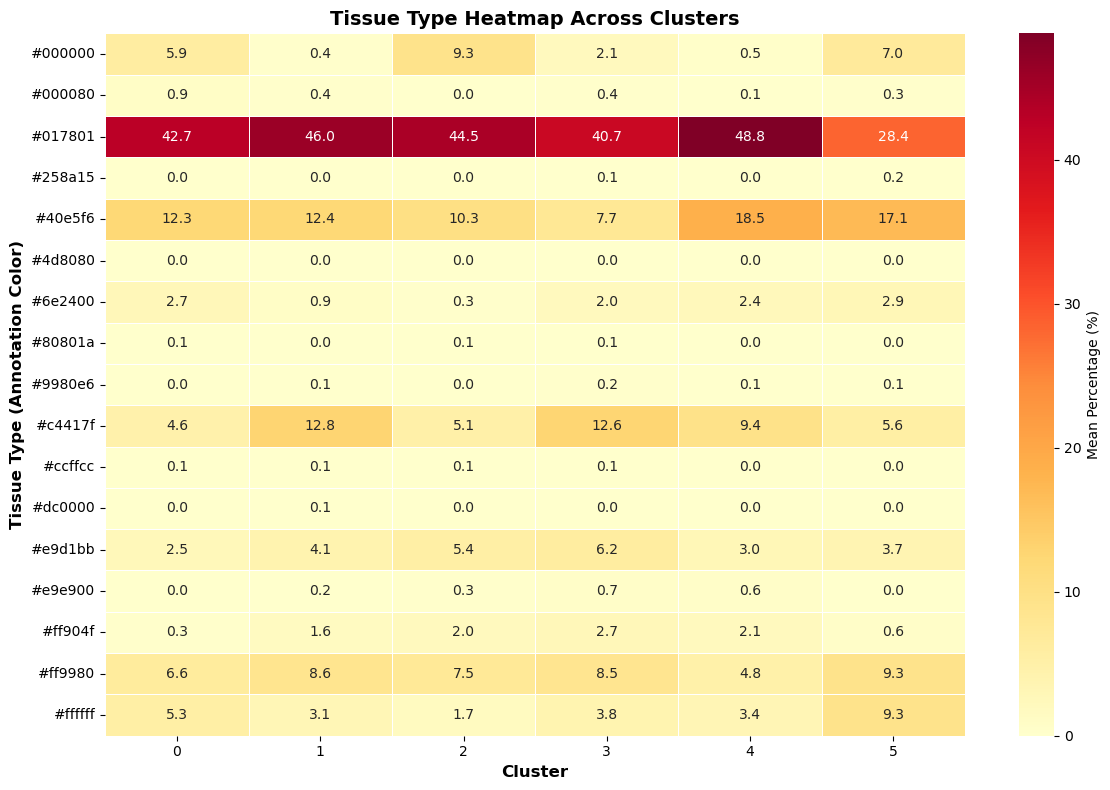

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# Heatmap: Tissue distribution across clusters
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(tissue_by_cluster_pivot.T, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='.1f',
            cbar_kws={'label': 'Mean Percentage (%)'},
            linewidths=0.5,
            ax=ax)

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Tissue Type (Annotation Color)', fontsize=12, fontweight='bold')
ax.set_title('Tissue Type Heatmap Across Clusters', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

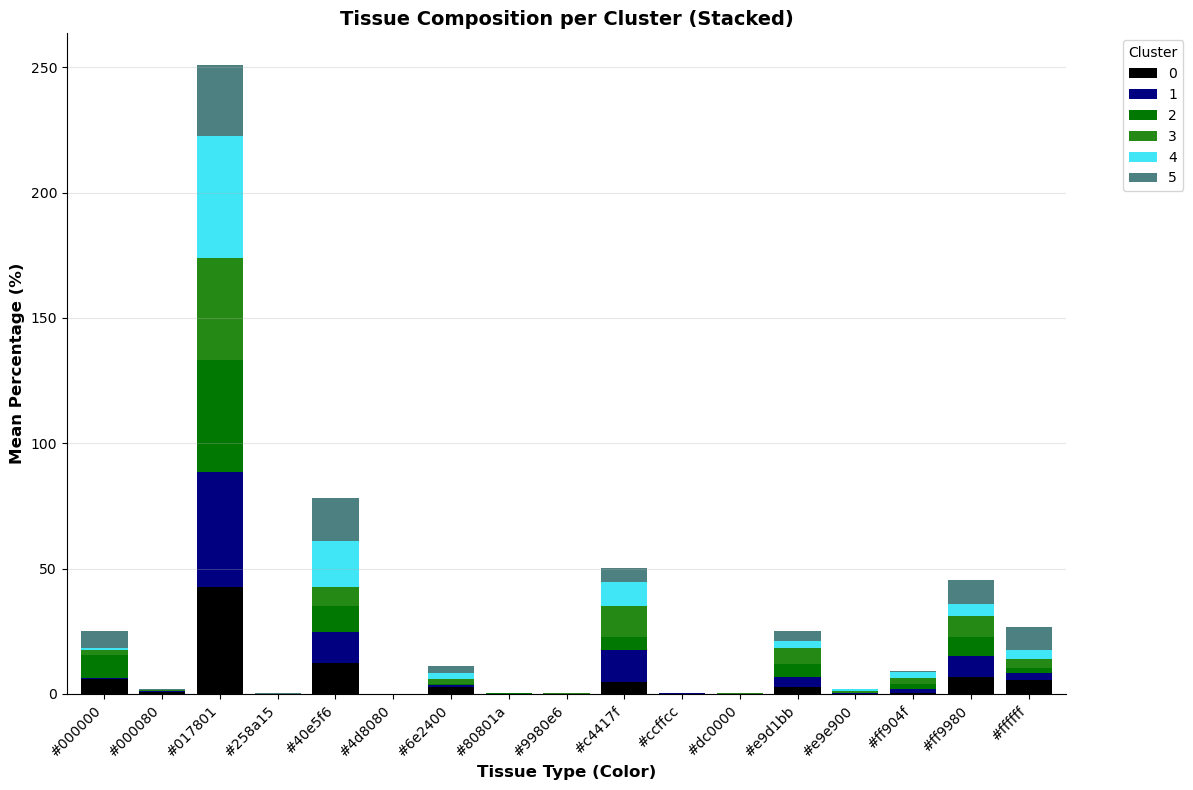

In [34]:
# Stacked bar plot: Tissue composition per cluster (shows proportions)
fig, ax = plt.subplots(figsize=(12, 8))

# Use actual colors from the data
tissue_colors_for_plot = [col if col.startswith('#') else f'C{idx}' 
                          for idx, col in enumerate(tissue_by_cluster_pivot.columns)]

tissue_by_cluster_pivot.T.plot(kind='bar', 
                                stacked=True, 
                                ax=ax,
                                color=tissue_colors_for_plot,
                                width=0.8)

ax.set_xlabel('Tissue Type (Color)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Tissue Composition per Cluster (Stacked)', fontsize=14, fontweight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()

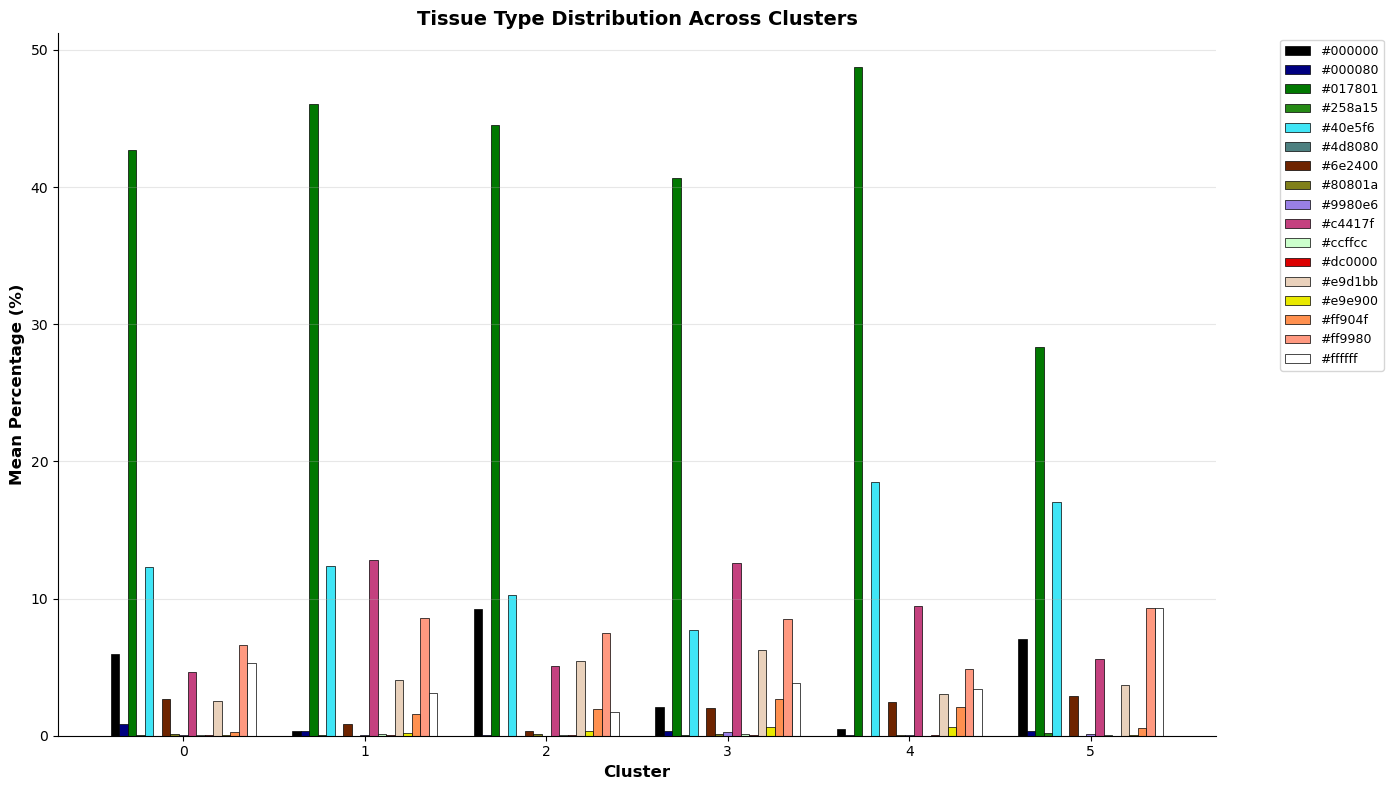

In [48]:
# Bar plot: Mean tissue percentage per cluster
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for grouped bar plot
x = np.arange(len(tissue_by_cluster_pivot.index))
width = 0.8 / len(tissue_by_cluster_pivot.columns)

# Plot bars for each tissue type
for idx, tissue_color in enumerate(tissue_by_cluster_pivot.columns):
    offset = (idx - len(tissue_by_cluster_pivot.columns)/2) * width + width/2
    values = tissue_by_cluster_pivot[tissue_color].values
    bars = ax.bar(x + offset, values, width, 
                   label=tissue_color, 
                   color=tissue_color if tissue_color.startswith('#') else None, 
                   linewidth=0.5, 
                   edgecolor='black')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Tissue Type Distribution Across Clusters', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tissue_by_cluster_pivot.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()

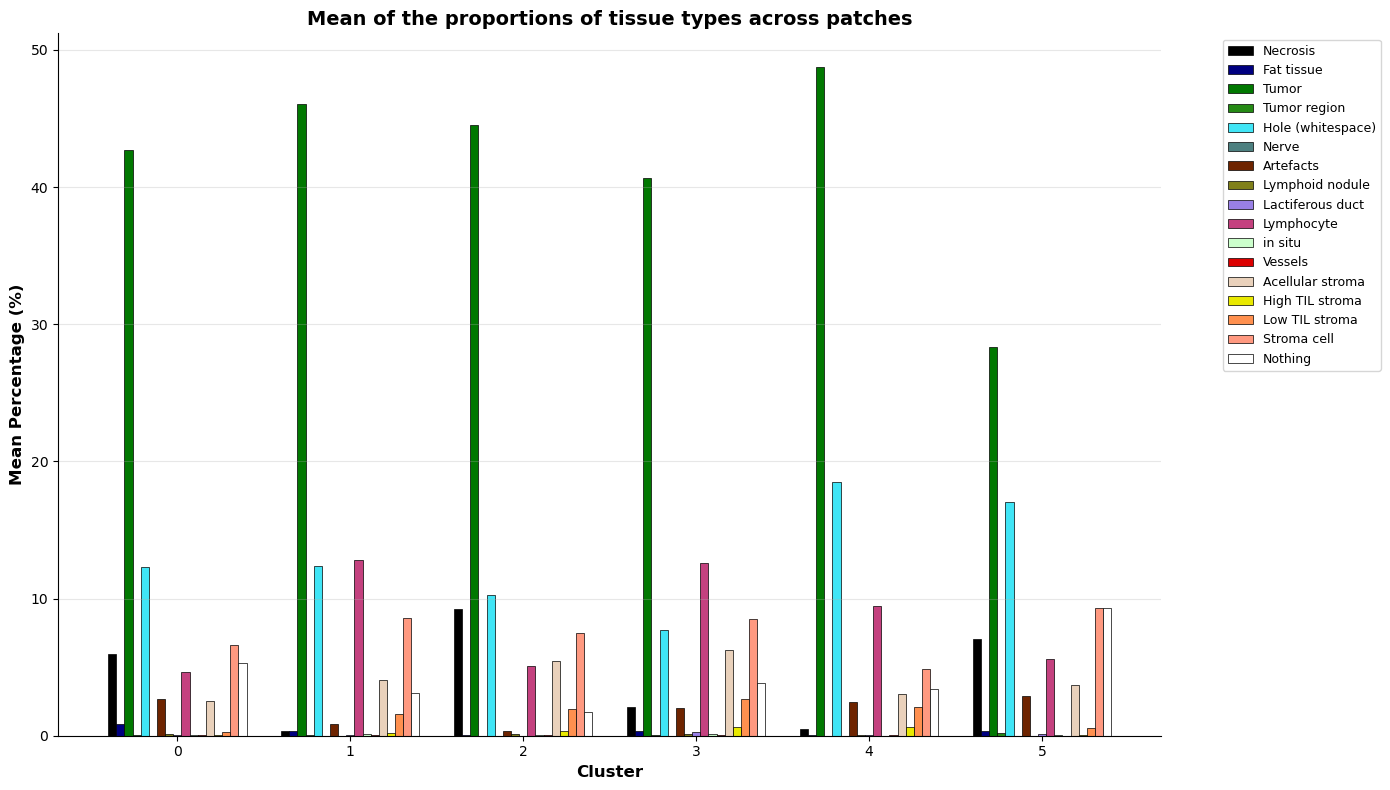

In [49]:
# Bar plot with tissue NAMES in legend: Mean tissue percentage per cluster
fig, ax = plt.subplots(figsize=(14, 8))

# Create reverse mapping from hex color to tissue name
hex_to_tissue = {v: k for k, v in colors.items()}

# Prepare data for grouped bar plot
x = np.arange(len(tissue_by_cluster_pivot.index))
width = 0.8 / len(tissue_by_cluster_pivot.columns)

# Plot bars for each tissue type
for idx, tissue_color in enumerate(tissue_by_cluster_pivot.columns):
    offset = (idx - len(tissue_by_cluster_pivot.columns)/2) * width + width/2
    values = tissue_by_cluster_pivot[tissue_color].values
    # Get tissue name from the hex color, or use the color itself if not found
    tissue_name = hex_to_tissue.get(tissue_color, tissue_color)
    bars = ax.bar(x + offset, values, width, 
                   label=tissue_name, 
                   color=tissue_color if tissue_color.startswith('#') else None,
                                      linewidth=0.5, 
                   edgecolor='black')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Mean of the proportions of tissue types across patches', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tissue_by_cluster_pivot.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()

In [39]:
# Group tissues by category using the mapping dictionary
# Create a mapping from hex color to category
hex_to_category = {}
for category, tissue_names in mapping.items():
    for tissue_name in tissue_names:
        if tissue_name in colors:
            hex_color = colors[tissue_name]
            hex_to_category[hex_color] = category

# Group the annotation data by category
df_annot_grouped = df_annot_simp.copy()
category_columns = {category: [] for category in mapping.keys()}

for hex_color in df_annot_simp.columns:
    category = hex_to_category.get(hex_color, 'unknown')
    if category in category_columns:
        category_columns[category].append(hex_color)

# Sum percentages for each category
df_annot_categories = pd.DataFrame()
for category, hex_colors in category_columns.items():
    available_colors = [c for c in hex_colors if c in df_annot_simp.columns]
    if available_colors:
        df_annot_categories[category] = df_annot_simp[available_colors].sum(axis=1)
    else:
        df_annot_categories[category] = 0

df_annot_categories

,invasive cancer,cancer in situ,immune infiltrate,connective tissue,breast glands,adipose tissue,nothing,necrosis
TNBC11_CN6_C1_patch002,0.000000,0.0,0.0,59.662222,0.0,0.0,2.417778,37.92
TNBC11_CN6_C1_patch010,24.284444,0.0,0.0,19.075556,0.0,0.0,56.640000,0.00
TNBC11_CN6_C1_patch012,55.573333,0.0,0.0,7.146667,0.0,0.0,37.280000,0.00
TNBC11_CN6_C1_patch018,41.991111,0.0,0.0,10.417778,0.0,0.0,47.591111,0.00
TNBC11_CN6_C1_patch019,28.622222,0.0,0.0,32.195556,0.0,0.0,39.182222,0.00
...,...,...,...,...,...,...,...,...
TNBC77_CN39_C1_patch187,0.000000,100.0,0.0,0.000000,0.0,0.0,0.000000,0.00
TNBC77_CN39_C1_patch410,0.000000,100.0,0.0,0.000000,0.0,0.0,0.000000,0.00
TNBC77_CN39_C1_patch670,0.000000,100.0,0.0,0.000000,0.0,0.0,0.000000,0.00
TNBC91_CN46_C2_patch270,0.000000,100.0,0.0,0.000000,0.0,0.0,0.000000,0.00


In [50]:
# Merge with cluster labels and compute mean per cluster
df_annot_categories_with_clusters = df_annot_categories.merge(
    df[['predicted_label']], 
    left_index=True, 
    right_index=True
)

# Calculate mean percentage per category per cluster
category_by_cluster = df_annot_categories_with_clusters.groupby('predicted_label').mean()

print("Mean category percentage per cluster:")
category_by_cluster

Mean category percentage per cluster:


,invasive cancer,cancer in situ,immune infiltrate,connective tissue,breast glands,adipose tissue,nothing,necrosis
predicted_label,,,,,,,,
0,42.717288,0.081466,4.834858,9.474639,0.030166,0.857559,20.292550,5.948237
1,46.040879,0.121906,12.945088,14.295521,0.080331,0.368111,16.319767,0.370832
2,44.501324,0.059837,5.518529,14.896819,0.006779,0.046235,12.324203,9.255421
3,40.756769,0.100577,13.430957,17.451485,0.237728,0.375500,13.550126,2.059865
4,48.773959,0.000000,10.133505,9.984792,0.080028,0.062974,24.341545,0.480572
5,28.528882,0.032396,5.607958,13.607361,0.104000,0.311153,29.274972,7.021694


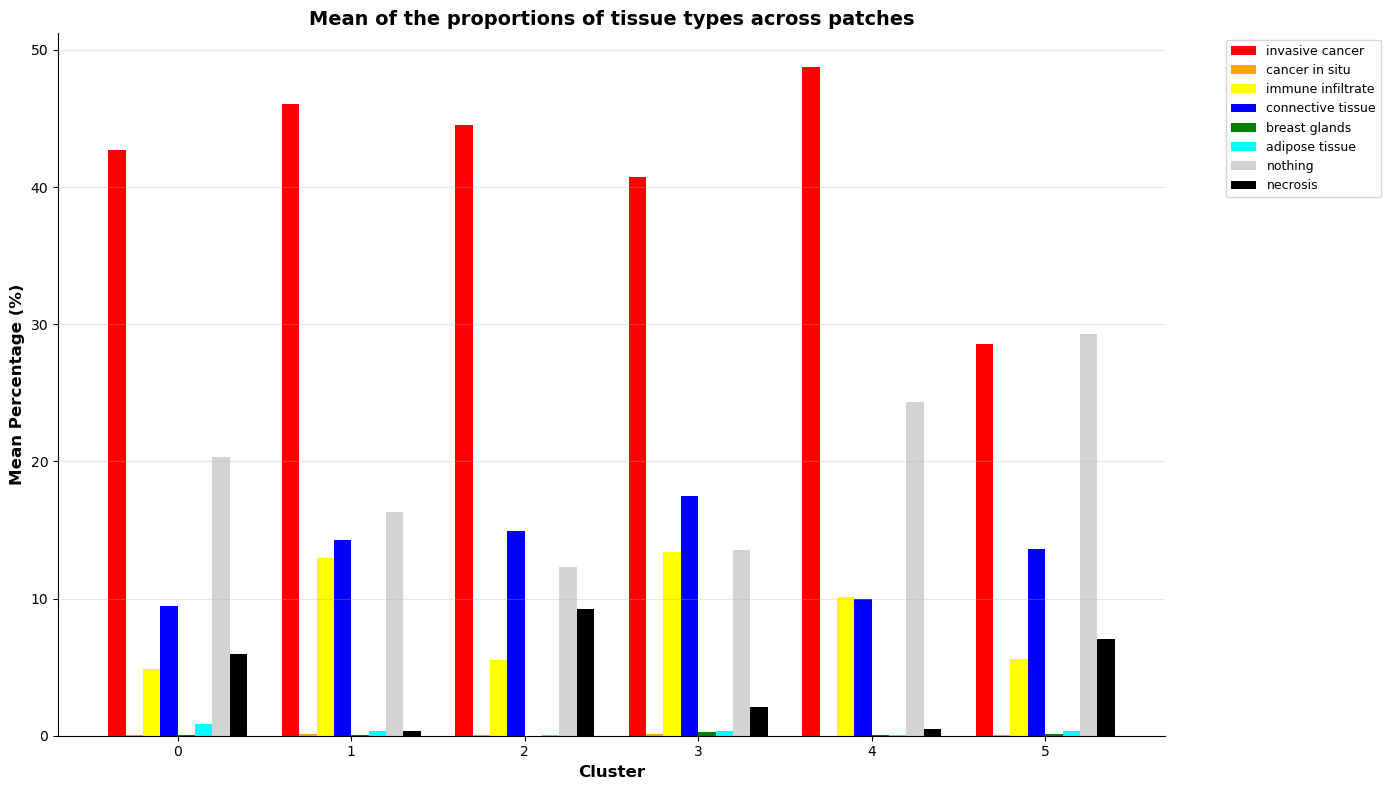

In [51]:
# Bar plot: Grouped category percentages with PALETTE colors
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for grouped bar plot
x = np.arange(len(category_by_cluster.index))
width = 0.8 / len(category_by_cluster.columns)

# Plot bars for each category using PALETTE colors
for idx, category in enumerate(category_by_cluster.columns):
    offset = (idx - len(category_by_cluster.columns)/2) * width + width/2
    values = category_by_cluster[category].values
    category_color = PALETTE.get(category, 'gray')
    bars = ax.bar(x + offset, values, width, 
                   label=category, 
                   color=category_color)

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Mean of the proportions of tissue types across patches', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_by_cluster.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='y', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()